In [31]:
import pandas as pd
import numpy as np
from PIL import Image
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

In [3]:
Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

In [4]:
Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [5]:
Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


In [6]:
for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=0

815


In [7]:
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max(Image_RGB)

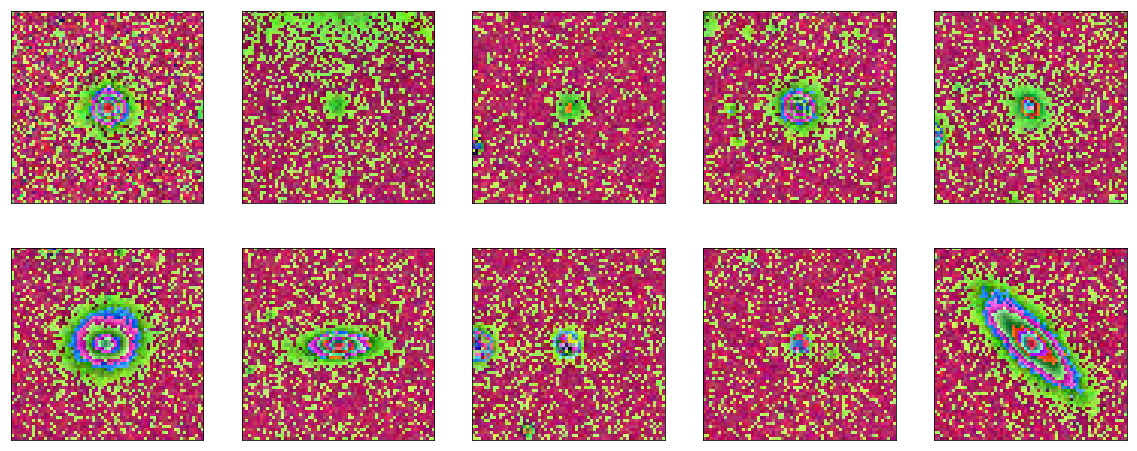

[1 1 1 1 1 1 1 0 2 1]


In [8]:
n=5
plt.figure(figsize=(20, 20*2/5))
for l in range(2):
    for i in range(n):
        ax = plt.subplot(2,n,l*n+i+1)
        plt.imshow((Image_RGB[10+l*5+i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()
print(Class[10:20])

In [9]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB

In [10]:
train_data = data
train_label = label
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)
index = [i for i in range(len(train_data))]
#random.shuffle(index)
train_data = train_data[index]
train_label = train_label[index]
print('total ',train_data.shape[0], ' samples')

train_data.shape: (14142, 64, 64, 3)
train_label.shape: (14142, 3)
total  14142  samples


In [18]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 600
#intermediate_dim_2 = 300
original_dim = 64*64

input_img = Input(shape=(64,64,3))

conv_1 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim_1, activation='tanh')(visual)
#h_2 = Dense(intermediate_dim_2, activation='tanh')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#h_3 = Dense(intermediate_dim_2,activation='tanh')(z)
h_4 = Dense(intermediate_dim_1,activation='tanh')(z)
h_5 = Dense(20*2*2,activation='relu')(h_4)
h_6 = Reshape((2,2,20))(h_5)


conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_6)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(upsample_10)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  


vae = Model(inputs=input_img, outputs=decoded) 
vae.compile(optimizer='rmsprop', loss=vae_loss) 



In [19]:
vae.fit(train_data[:8000], train_data[:8000],  
        shuffle=True,  
        epochs=40,    
        batch_size=batch_size,  
        validation_data=(train_data[8000:8500],train_data[8000:8500]),callbacks=[EarlyStopping])  

Train on 8000 samples, validate on 500 samples
Epoch 1/40
8000/8000 [==============================] - 17s - loss: -7290.8826 - val_loss: -7537.6802
Epoch 2/40
8000/8000 [==============================] - 16s - loss: -7815.1748 - val_loss: -7762.3948
Epoch 3/40
8000/8000 [==============================] - 17s - loss: -7907.3430 - val_loss: -7937.5150
Epoch 4/40
8000/8000 [==============================] - 17s - loss: -7904.0757 - val_loss: -7742.8182
Epoch 5/40
8000/8000 [==============================] - 17s - loss: -7970.0418 - val_loss: -7892.1181
Epoch 6/40
8000/8000 [==============================] - 17s - loss: -8002.5010 - val_loss: -7791.5149
Epoch 7/40
8000/8000 [==============================] - 17s - loss: -8004.8033 - val_loss: -7919.5388
Epoch 8/40
3200/8000 [===========>..................] - ETA: 10s - loss: -7872.2226

KeyboardInterrupt: 

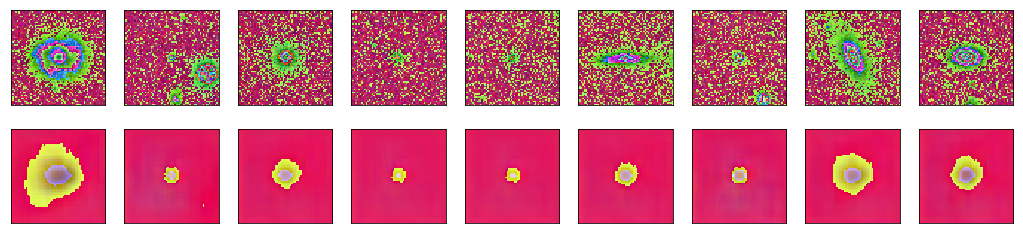

In [20]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)

decoded_imgs = vae.predict(train_data[8000:9000],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9000][i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

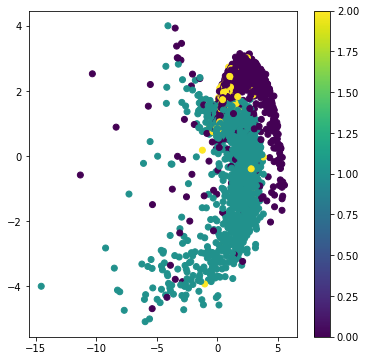

In [25]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:14000], batch_size=batch_size)  
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:14000])
plt.colorbar()
plt.show()

Automatically created module for IPython interactive environment
standard: 3.7 sec
modified: 4.4 sec
Isomap: 28 sec
MDS: 1.1e+02 sec
SpectralEmbedding: 1.7 sec
t-SNE: 86 sec


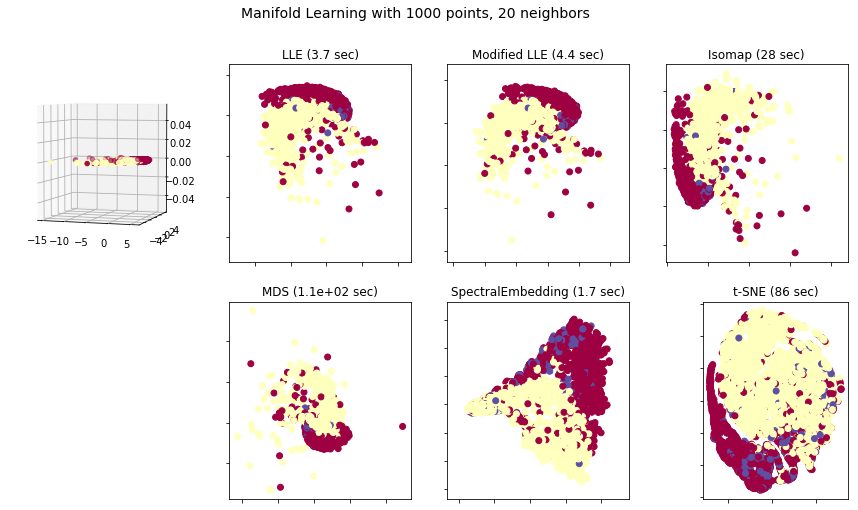

In [26]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from time import time
from sklearn import cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X = np.asarray(x_vis,dtype='float64')
color = label_value[8000:14000]
#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#X = X.astype(np.float32)
n_neighbors = 20
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(241, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(241, projection='3d')
    plt.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(242 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(244)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(246)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(247)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

In [37]:
model_conv_1 = Model(input_img,conv_1)
model_pool_1 = Model(input_img,maxpool_1)
model_conv_2 = Model(input_img,conv_2)
model_pool_2 = Model(input_img,maxpool_2)
model_conv_3 = Model(input_img,conv_3)
model_pool_3 = Model(input_img,maxpool_3)
model_conv_4 = Model(input_img,conv_4)
model_pool_4 = Model(input_img,maxpool_4)
model_conv_5 = Model(input_img,conv_5)
model_pool_5 = Model(input_img,maxpool_5)
model_conv_6 = Model(input_img,conv_6)
model_up_6 = Model(input_img,upsample_6)
model_conv_7 = Model(input_img,conv_7)
model_up_7 = Model(input_img,upsample_7)
model_conv_8 = Model(input_img,conv_8)
model_up_8 = Model(input_img,upsample_8)
model_conv_9 = Model(input_img,conv_9)
model_up_9 = Model(input_img,upsample_9)
model_conv_10 = Model(input_img,conv_10)
model_up_10 = Model(input_img,upsample_10)

In [38]:
lyr = []
lyr.append(model_conv_1)
lyr.append(model_pool_1)
lyr.append(model_conv_2)
lyr.append(model_pool_2)
lyr.append(model_conv_3)
lyr.append(model_pool_3)
lyr.append(model_conv_4)
lyr.append(model_pool_4)
lyr.append(model_conv_5)
lyr.append(model_pool_5)
lyr.append(model_conv_6)
lyr.append(model_up_6)
lyr.append(model_conv_7)
lyr.append(model_up_7)
lyr.append(model_conv_8)
lyr.append(model_up_8)
lyr.append(model_conv_9)
lyr.append(model_up_9)
lyr.append(model_conv_10)
lyr.append(model_up_10)

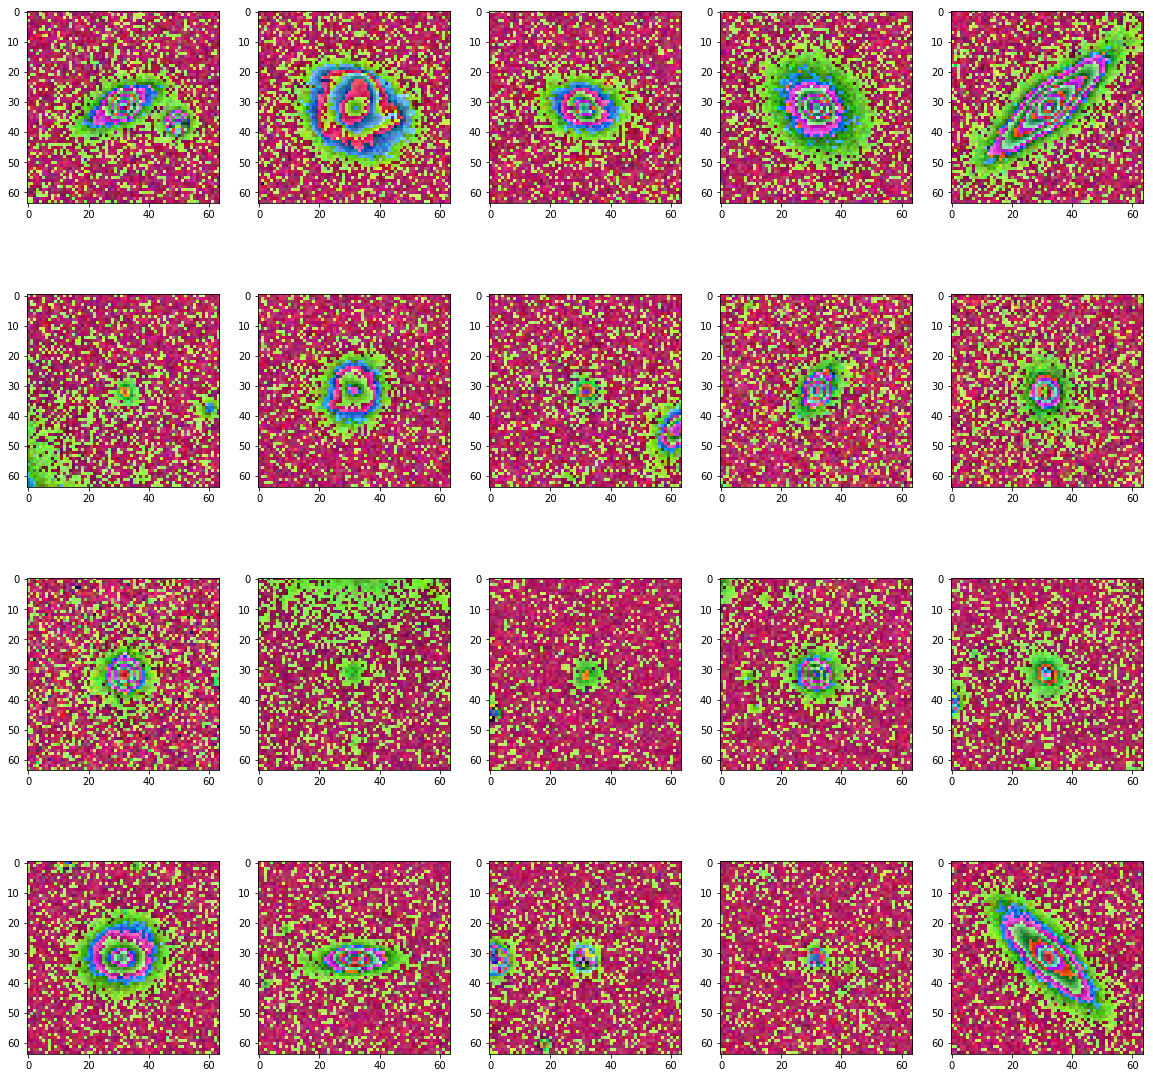

In [29]:
plt.figure(figsize=(20, 20))
for number in range(20):
    ax = plt.subplot(4,5,number+1)
    plt.imshow(train_data[number])
plt.show()

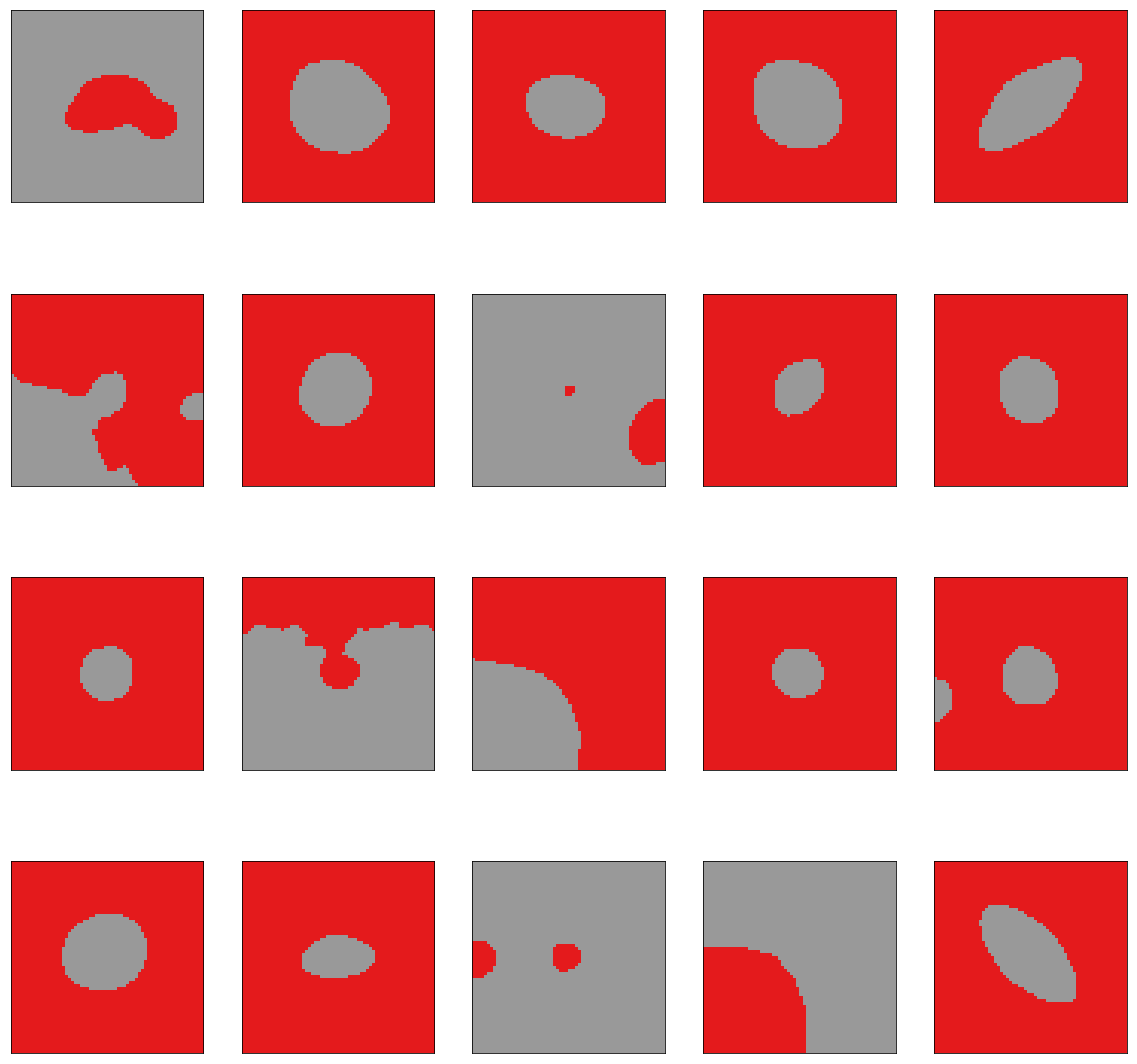

In [32]:
fig = plt.figure(figsize=(20, 20))
for number in range(20):
    No_ = number
    hypercolumns = []
    for i in range(np.shape(lyr)[0]):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[0:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
    hypercolumns = np.asarray(hypercolumns)
    m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
    kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
    cluster_labels = kmeans.fit_predict(m)
    
    imcluster = np.zeros((64,64))
    imcluster = imcluster.reshape((64*64,))
    imcluster = cluster_labels
    ax = plt.subplot(4,5,number+1)
    plt.imshow(imcluster.reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### The results above are from under-trained model, if I train the model with more epochs:

In [33]:
vae.fit(train_data[:8000], train_data[:8000],  
        shuffle=True,  
        epochs=10,    
        batch_size=batch_size,  
        validation_data=(train_data[8000:8500],train_data[8000:8500]),callbacks=[EarlyStopping])  

Train on 8000 samples, validate on 500 samples
Epoch 1/10
8000/8000 [==============================] - 16s - loss: -8026.5749 - val_loss: -7848.7109
Epoch 2/10
8000/8000 [==============================] - 16s - loss: -8023.3599 - val_loss: -7970.4090
Epoch 3/10
8000/8000 [==============================] - 16s - loss: -8019.7727 - val_loss: -7957.1173
Epoch 4/10
8000/8000 [==============================] - 17s - loss: -8029.4419 - val_loss: -7984.9273
Epoch 5/10
8000/8000 [==============================] - 17s - loss: -8041.8572 - val_loss: -7992.5858
Epoch 6/10
8000/8000 [==============================] - 17s - loss: -8040.4676 - val_loss: -7955.4285
Epoch 7/10
8000/8000 [==============================] - 17s - loss: -8056.0411 - val_loss: -7981.7064
Epoch 8/10
8000/8000 [==============================] - 17s - loss: -8046.7897 - val_loss: -7977.6415
Epoch 9/10
8000/8000 [==============================] - 17s - loss: -8036.5959 - val_loss: -7979.0596
Epoch 10/10
8000/8000 [============

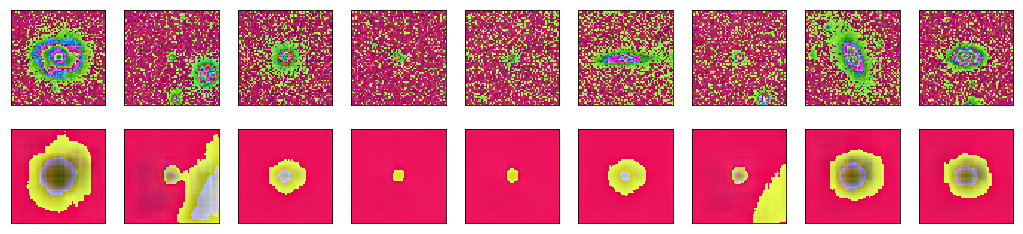

In [34]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)

decoded_imgs = vae.predict(train_data[8000:9000],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9000][i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

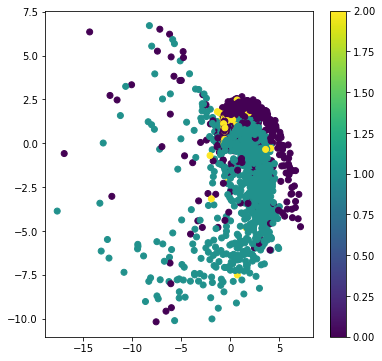

In [35]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:14000], batch_size=batch_size)  
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:14000])
plt.colorbar()
plt.show()

Automatically created module for IPython interactive environment
standard: 2.9 sec
modified: 3.7 sec
Isomap: 28 sec
MDS: 1.1e+02 sec
SpectralEmbedding: 1.6 sec
t-SNE: 98 sec


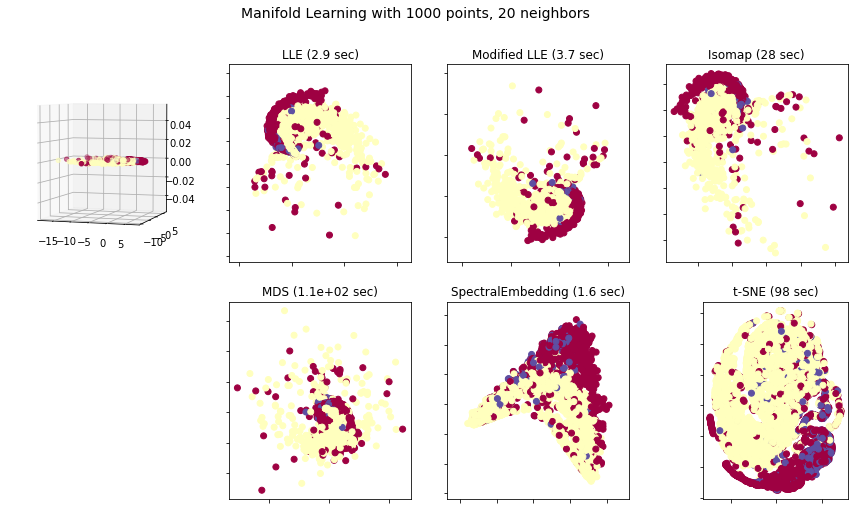

In [36]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from time import time
from sklearn import cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X = np.asarray(x_vis,dtype='float64')
color = label_value[8000:14000]
#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#X = X.astype(np.float32)
n_neighbors = 20
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(241, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(241, projection='3d')
    plt.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(242 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(244)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(246)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(247)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

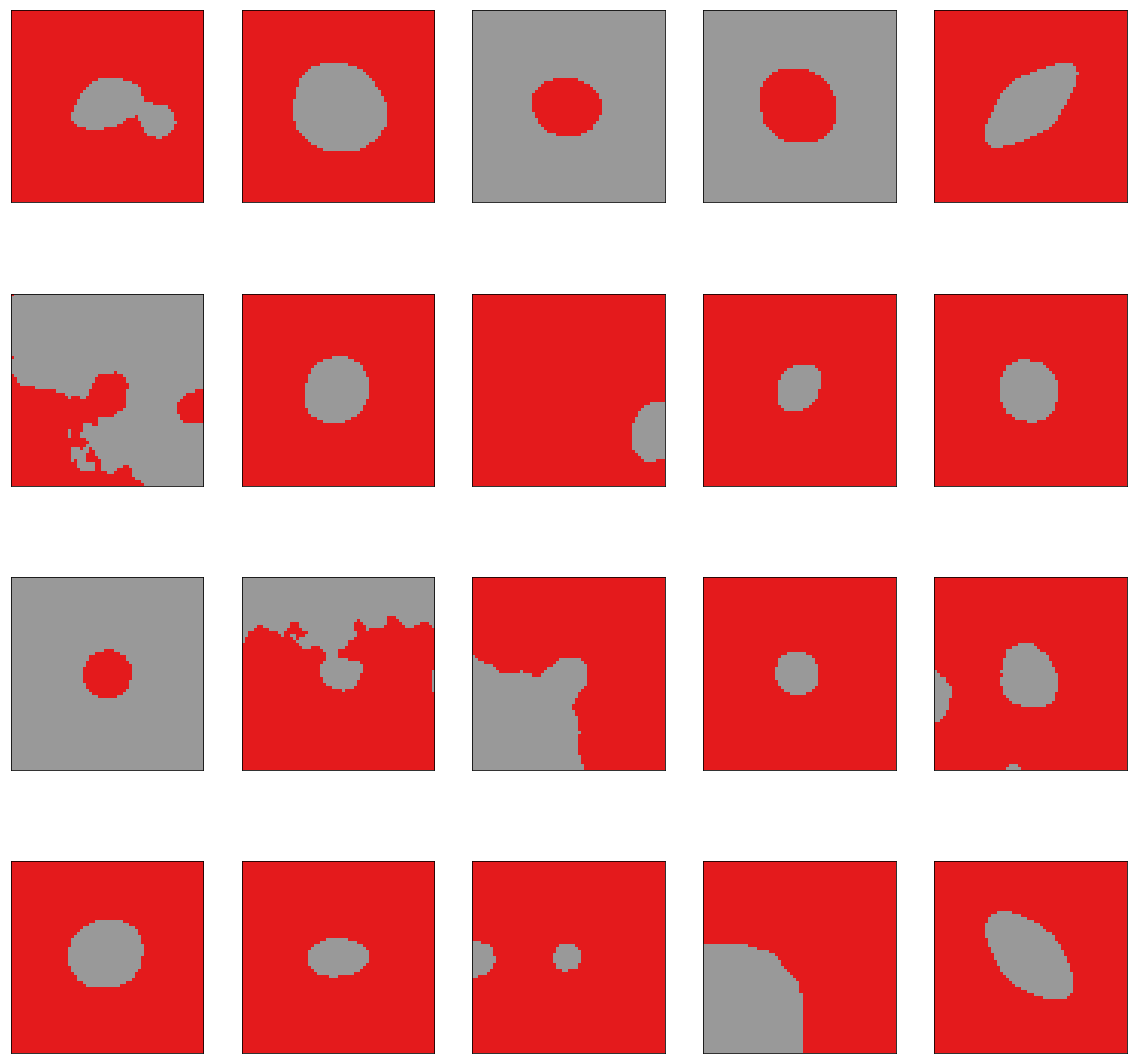

In [39]:
fig = plt.figure(figsize=(20, 20))
for number in range(20):
    No_ = number
    hypercolumns = []
    for i in range(np.shape(lyr)[0]):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[0:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
    hypercolumns = np.asarray(hypercolumns)
    m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
    kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
    cluster_labels = kmeans.fit_predict(m)
    
    imcluster = np.zeros((64,64))
    imcluster = imcluster.reshape((64*64,))
    imcluster = cluster_labels
    ax = plt.subplot(4,5,number+1)
    plt.imshow(imcluster.reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()